In [1]:
import os
import pprint as pp

import geopandas as gpd
import teotil3 as teo

# TEOTIL3 
# Tutorial 02: NVE's "regine" catchments

Although, in principle, TEOTIL3 can be used with any user-defined set of catchments, in practice it is almost always used with [NVE's "regine" catchment network](https://www.nve.no/kart/kartdata/vassdragsdata/nedborfelt-regine/), which provides the most detailed subdivision of Norwegian watersheds currently available. Within the regine dataset, each catchment (or sub-, inter- or coastal catchment) is assigned a unique ID based on its position in the catchment hierarchy (see [here](https://www.nve.no/media/2297/regines-inndelingssystem.pdf) for a detailed description).

As described in Tutorial 01, one of the core inputs to TEOTIL3 is an adjacency matrix describing hydrological connectivity between catchments. TEOTIL3 includes an algorithm to determine the hydrological order from the regine codes - see the notebook for `T2-2`, [here](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-2_catchment_hierarchy.ipynb), for details. **This algortihm is not perfect**, since the regine codes alone do not contain enough information to uniquely determine hydrological sorting. Nevertheless, the new algorithm includes a number of improvements compared to previous versions of the model (see [here](https://github.com/NIVANorge/teotil3/issues/11) for a comparison).

This tutorial illustrates some features of TEOTIL3 designed to make it easier to work with the regine catchments.

## 1. Get geospatial data for the regine catchments

Core datasets for TEOTIL3 - including the regine catchments - have been updated as part of Task 2.1 (see the development notebooks [here](https://github.com/NIVANorge/teotil3/tree/main/notebooks/development)). The code below reads the latest catchment dataset, together with the latest administrative boundaries (both from 2022).

In [2]:
# Datasets of interest
reg_year = 2022
admin_year = 2022
data_fold = f"/home/jovyan/shared/teotil3/core_data_june_{reg_year}"
teo_gpkg = os.path.join(data_fold, "tidied", f"teotil3_data.gpkg")
reg_gdf = gpd.read_file(
    teo_gpkg, layer=f"regine_{reg_year}_admin_{admin_year}", driver="GPKG"
)
reg_gdf.head()

,regine,a_cat_land_km2,a_cat_poly_km2,upstr_a_km2,upstr_runoff_Mm3/yr,q_sp_m3/s/km2,runoff_mm/yr,q_cat_m3/s,vassom,komnr,...,a_glacier_km2,a_lake_km2,a_other_km2,a_sea_km2,a_upland_km2,a_urban_km2,a_wood_km2,ar50_tot_a_km2,a_lake_nve_km2,geometry
0,001.10,1.16,1.442790,0.00,0.00,0.01393,439.597368,0.016159,001,3001,...,0.0,0.000013,3.116485e-01,0.281940,0.000000,0.000000,0.849188,0.849201,0.000000,"MULTIPOLYGON (((297006.830 6543966.950, 297169..."
1,001.1A1,1.43,1.432479,777.90,448.15,0.01419,447.802344,0.020292,001,3001,...,0.0,0.048098,2.223036e-03,0.000067,0.004615,0.000000,1.377476,1.430189,0.043955,"MULTIPOLYGON (((297505.440 6543157.790, 297543..."
2,001.1A20,0.34,0.340160,777.90,448.15,0.01036,326.936736,0.003522,001,3001,...,0.0,0.036623,0.000000e+00,0.000045,0.000000,0.000000,0.303492,0.340114,0.000000,"MULTIPOLYGON (((297770.368 6543429.036, 297787..."
3,001.1A2A,17.65,17.647822,58.96,22.97,0.01210,381.846960,0.213565,001,3001,...,0.0,0.122567,0.000000e+00,0.000000,0.467374,0.131585,15.030746,17.647822,0.186340,"MULTIPOLYGON (((299678.370 6544460.320, 299667..."
4,001.1A2B,41.30,41.298255,41.30,16.23,0.01245,392.892120,0.514185,001,3001,...,0.0,7.513687,1.421085e-14,0.000000,2.250799,0.161524,29.798394,41.298255,7.344123,"MULTIPOLYGON (((303353.460 6552989.330, 303341..."


## 2. Determine hydrological connectivity

The function `teo.io.assign_regine_hierarchy` attempts to determine the hydrological order from the regine codes. See [this notebook](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-2_catchment_hierarchy.ipynb) for a description of how the algorithm works, and the issue [here](https://github.com/NIVANorge/teotil3/issues/11) for an overview of its limitations.

In [3]:
# Determine hydrological connectivity
reg_gdf = teo.io.assign_regine_hierarchy(
    reg_gdf,
    regine_col="regine",
    regine_down_col="regine_down",
    order_coastal=False,
    nan_to_vass=True,
    land_to_vass=True,
    add_offshore=True,
)
reg_gdf.head()

100.00 % of regines assigned.


,regine,regine_down,a_cat_land_km2,a_cat_poly_km2,upstr_a_km2,upstr_runoff_Mm3/yr,q_sp_m3/s/km2,runoff_mm/yr,q_cat_m3/s,vassom,...,a_glacier_km2,a_lake_km2,a_other_km2,a_sea_km2,a_upland_km2,a_urban_km2,a_wood_km2,ar50_tot_a_km2,a_lake_nve_km2,geometry
0,001.10,001.,1.16,1.442790,0.00,0.00,0.01393,439.597368,0.016159,001,...,0.0,0.000013,3.116485e-01,0.281940,0.000000,0.000000,0.849188,0.849201,0.000000,"MULTIPOLYGON (((297006.830 6543966.950, 297169..."
1,001.1A1,001.,1.43,1.432479,777.90,448.15,0.01419,447.802344,0.020292,001,...,0.0,0.048098,2.223036e-03,0.000067,0.004615,0.000000,1.377476,1.430189,0.043955,"MULTIPOLYGON (((297505.440 6543157.790, 297543..."
2,001.1A20,001.1A1,0.34,0.340160,777.90,448.15,0.01036,326.936736,0.003522,001,...,0.0,0.036623,0.000000e+00,0.000045,0.000000,0.000000,0.303492,0.340114,0.000000,"MULTIPOLYGON (((297770.368 6543429.036, 297787..."
3,001.1A2A,001.1A20,17.65,17.647822,58.96,22.97,0.01210,381.846960,0.213565,001,...,0.0,0.122567,0.000000e+00,0.000000,0.467374,0.131585,15.030746,17.647822,0.186340,"MULTIPOLYGON (((299678.370 6544460.320, 299667..."
4,001.1A2B,001.1A2A,41.30,41.298255,41.30,16.23,0.01245,392.892120,0.514185,001,...,0.0,7.513687,1.421085e-14,0.000000,2.250799,0.161524,29.798394,41.298255,7.344123,"MULTIPOLYGON (((303353.460 6552989.330, 303341..."


## 3. Explore the regine dataset

The basic regine dataset shown above does not yet contain enough information to simulate nutrient fluxes, but it does include a lot of spatial information regarding the catchments themselves. As illustrated in Tutorial 01, TEOTIL3 includes some useful tools for visualising the catchment network. The first step is to use the adjacency matrix created from the regine codes to build a directed acyclic graph (DAG) of the catchment hierarchy.

In [4]:
# Build network graph from adjacency matrix
g = teo.model.build_graph(reg_gdf, id_col="regine", next_down_col="regine_down")

**This network is a representation of the entire Norwegian hydrological system** and includes data for more than 24000 (sub-)catchments. As a simple example, we will explore the network in the vicinity of regine `028.A3`.

Local attributes for catchment '028.A3':
{'a_agri_km2': 1.1364909071368665,
 'a_cat_land_km2': 1.61,
 'a_cat_poly_km2': 1.598408204867726,
 'a_glacier_km2': 0.0,
 'a_lake_km2': 0.04780785713574248,
 'a_lake_nve_km2': 0.0,
 'a_other_km2': 0.0,
 'a_sea_km2': 0.0,
 'a_upland_km2': 0.0,
 'a_urban_km2': 0.3255519196352737,
 'a_wood_km2': 0.0885575209600425,
 'ar50_tot_a_km2': 1.5984082048679251,
 'fylnr': '11',
 'geometry': <shapely.geometry.multipolygon.MultiPolygon object at 0x7f4e37084250>,
 'komnr': '1120',
 'ospar_region': 'North Sea',
 'q_cat_m3/s': 0.044645300000000006,
 'q_sp_m3/s/km2': 0.02773,
 'regine': '028.A3',
 'regine_down': '028.A2',
 'runoff_mm/yr': 875.0922480000002,
 'upstr_a_km2': 222.28,
 'upstr_runoff_Mm3/yr': 323.32,
 'vassom': '028'}


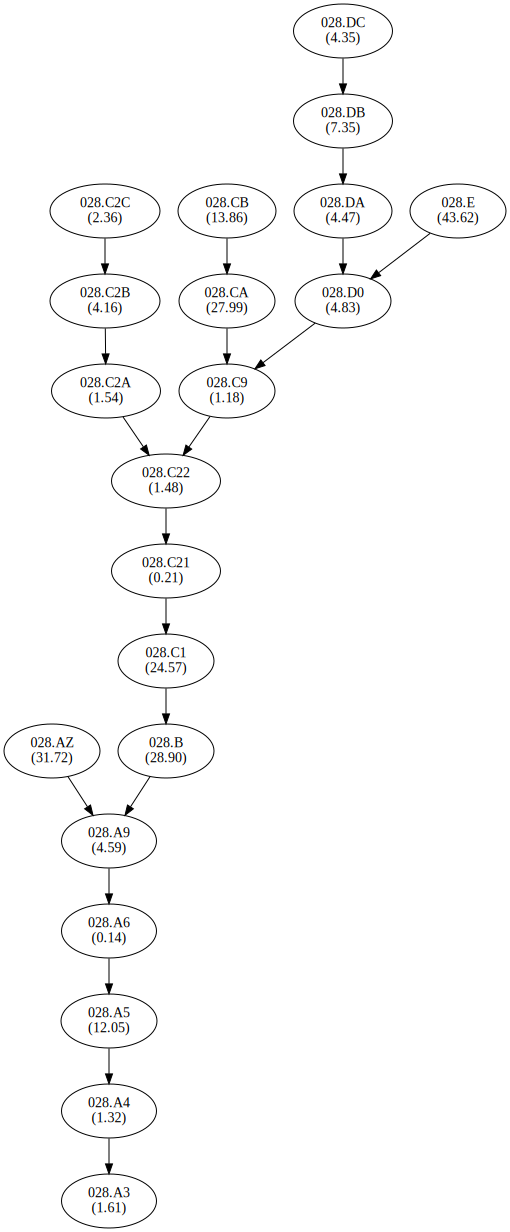

In [5]:
# Catchment of interest
reg_id = "028.A3"

# Get 'local' data for catchment
print(f"Local attributes for catchment '{reg_id}':")
pp.pprint(g.nodes[reg_id]["local"])

# Plot network upstream
teo.vis.plot_network(g, reg_id, direct="up", stat="local", quant="a_cat_land_km2")

Similarly, by using `direct="down"`, we can plot the network downstream to the coast (and into the OSPAR maritime regions - see section 3.2.4 [here](https://nivanorge.github.io/teotil2/pages/07_1000_lakes.html) for an overview of these).

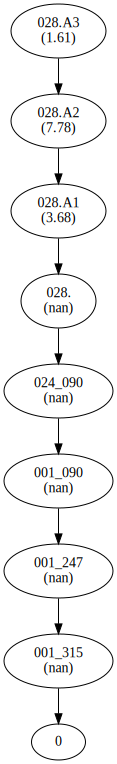

In [6]:
# Plot network downstream
teo.vis.plot_network(g, reg_id, direct="down", stat="local", quant="a_cat_land_km2")

Because we have spatial data representing the regine catchments (i.e. because `reg_gdf` is a *geo*dataframe, rather than a standard dataframe), we can also visualise the catchments spatially using `teo.vis.plot_catchment`. In particular, note the keyword arguments `include_connected` and `direct`:

 * If `include_connected=False`, the `direct` argument is ignored and only the specified regine is plotted
 
 * If `include_connected=True` and `direct="up"`, the specified regine will be merged with all upstream regines to create a complete catchment (rather than a sub- or inter-catchment). This will then be plotted
 
 * If `include_connected=True` and `direct="down"`, the specified regine will be merged with all regines on the downstream path and then plotted
 
These options are illustrated below.

<AxesSubplot:>

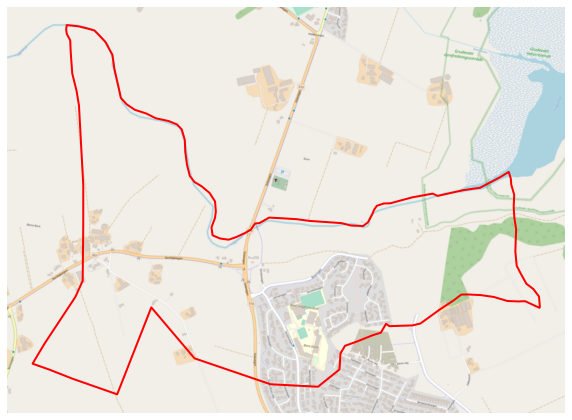

In [7]:
# Plot just the specified regine
gdf, ax = teo.vis.plot_catchment(
    g, reg_id, reg_gdf, id_col="regine", include_connected=False
)
ax

<AxesSubplot:>

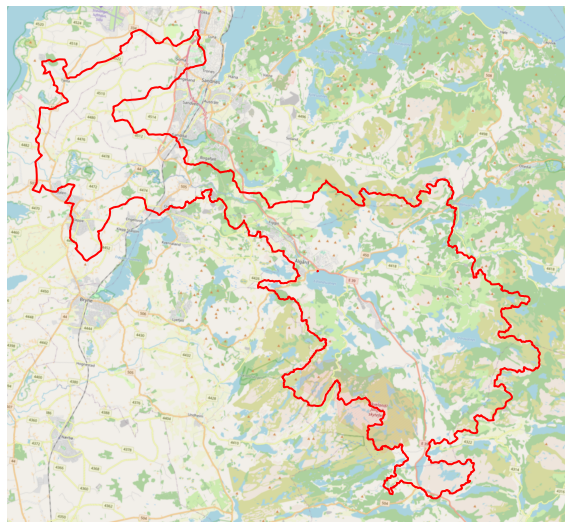

In [8]:
# Plot the specified regine and all contributing regines upstream
gdf, ax = teo.vis.plot_catchment(
    g, reg_id, reg_gdf, id_col="regine", include_connected=True, direct="up"
)
ax

<AxesSubplot:>

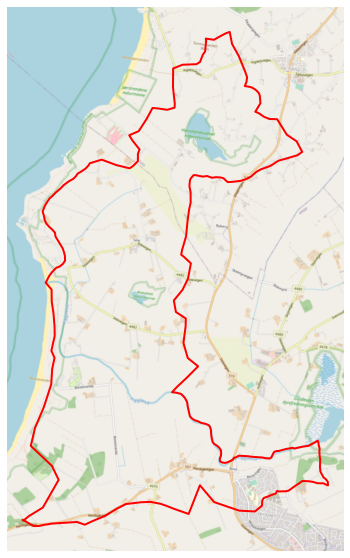

In [9]:
# Plot the specified regine and other regines on the downstream path
gdf, ax = teo.vis.plot_catchment(
    g, reg_id, reg_gdf, id_col="regine", include_connected=True, direct="down"
)
ax

Finally, because we included the keyword argument `add_offshore=True` when we assigned the regine hierarchy (see section 2, above), we can also aggregate data based on OSPAR maritime areas. For example, vassdragsområder `001` to `023` all drain to Skagerrak (see [here](https://github.com/NIVANorge/teotil3/blob/main/data/vassdragsomrader_ospar_regions.csv)), and including `add_offshore=True` means that `001_023` has been added to the adjacency matrix (by extending the basic regine dataset). The entire drainage area for Skagerrak can therefore be visualised efficiently, as shown below.

<AxesSubplot:>

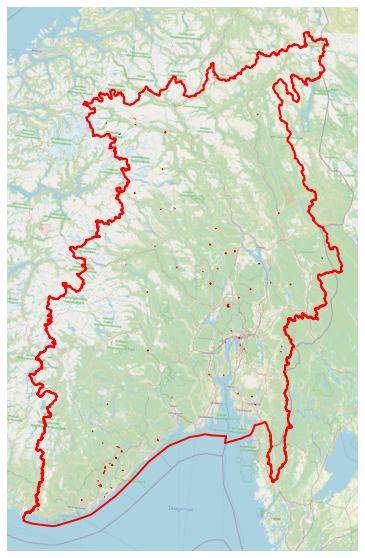

In [10]:
gdf, ax = teo.vis.plot_catchment(
    g, "001_023", reg_gdf, id_col="regine", include_connected=True, direct="up"
)
ax